https://oauth.vk.com/authorize?client_id=6121396&scope=1&redirect_uri=https://oauth.vk.com/blank.html&display=page&response_type=token&revoke=1

In [1]:
pip install cython pillow>=7.0.0 numpy>=1.18.1 opencv-python>=4.1.2 torch>=1.9.0 --extra-index-url https://download.pytorch.org/whl/cpu torchvision>=0.10.0 --extra-index-url https://download.pytorch.org/whl/cpu pytest==7.1.3 tqdm==4.64.1 scipy>=1.7.3 matplotlib>=3.4.3 mock==4.0.3

zsh:1: 7.0.0 not found
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imageai --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 1.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
group_key = 'vk1.a.TeWi79plYP3gMA3B-1YZYQ2UAPXpM_9yz_tkhtYF-aylOGlu5xwqr2TIABetNarvAQNp06nFIZ3zR_WHcvjVQasQqb_77AzttZzynWdfCK5VqG3gLk8qz4wDbsej07I70-WHTnrxHeOm30op9d2e90GA1PovKXgTKMGIP2CXObX5RueDkXmjycupY6K5ZgeUcOYUhleCWIdV0RoPhcy5CA'
personal_key = 'vk1.a.HJxq7jgW-6cigdFhNtOF78dEd5yt2qg42lt3eLRmwecxFUQDFgcfIvBVT_l1TGoPibNJWqAqsV879MX5yoIUfzNIBuDHD0HdT-oE9owcypf7AyBScmebKRLRmIv5uA18HSsfBQ_NTyGSW21j3WZEzap1GooMoUtGEKsD_xguH0cY5ecfZ0F87tIekdCvq-Y9'

In [14]:
import vk_api 
from vk_api.longpoll import VkLongPoll, VkEventType
from vk_api.utils import get_random_id

import requests, io, cv2
import pandas as pd
import numpy as np
from PIL import Image

In [15]:
from typing import List, Dict

import yake
from PIL import Image


def get_url_user(person_info: List) -> str:
    return person_info[0]["crop_photo"]['photo']['sizes'][-1]["url"]


def get_url_wall(wall_info: Dict) -> str:
    return wall_info["items"][0]["attachments"][0]['link']['photo']["sizes"][-1]["url"]


def get_url_post(post_info: List) -> str:
    return post_info[0]['attachments'][0]['photo']['sizes'][-1]["url"]


def get_text_post(post_info: List) -> str:
    return post_info[0]['text']


def get_text_wall(wall_info: Dict) -> str:
    return wall_info["items"][0]['text']


def get_np_image_from_url(url: str) -> np.ndarray:
    response = requests.get(url)
    bytes_im = io.BytesIO(response.content)
    cv_im = np.array(Image.open(bytes_im))

    return cv_im


def save_np_image(np_image: np.ndarray, save_path: str = "image.jpg") -> None:
    im = Image.fromarray(np_image)
    im.save(save_path)    


def send_image(user_id: int, path_to_image: str = "image.jpg"):
    photo = upload.photo_messages('image.jpg')
    owner_id = photo[0]['owner_id']
    photo_id = photo[0]['id']
    access_key = photo[0]['access_key']
    attachment = f'photo{owner_id}_{photo_id}_{access_key}'
    vk.messages.send(                
        user_id=user_id,
        random_id=get_random_id(),
        attachment=attachment,
        keyboard=_get_settings_keyboard()
    )


def define_action(event) -> int:
    for i in range(len(comands)):
        if event.text.startswith(comands[i]):
            return i

    return -1

In [16]:
class KeyWordExtractor():
    def __init__(self, kw_extractor = yake.KeywordExtractor(), language: str = "ru", max_ngram_size: int = 3, deduplication_threshold: float = 0.9, numOfKeywords: int = 20):
        self.kw_extractor = kw_extractor
        self.language = language
        self.max_ngram_size = max_ngram_size
        self.deduplication_threshold = deduplication_threshold
        self.numOfKeywords = numOfKeywords

    def extract_keywords(self, text: str = "") -> str:
        custom_kw_extractor = yake.KeywordExtractor(lan=self.language, n=self.max_ngram_size, dedupLim=self.deduplication_threshold, top=self.numOfKeywords, features=None)
        return  "; ".join([kw[0] for kw in custom_kw_extractor.extract_keywords(text)])


class MyFancyDetector:
    def __init__(self, model: str = "yolov3.pt"):
        self.detector = ObjectDetection()
        self.detector.setModelTypeAsYOLOv3()
        self.detector.setModelPath(model)
        self.detector.loadModel()

    def detect(self, np_image) -> None:
        processed_image, detections, extracted_objects = self.detector.detectObjectsFromImage(
            input_image=np_image,
            output_type="array",
            extract_detected_objects=True, 
            minimum_percentage_probability=30
        )

        save_np_image(processed_image)

In [17]:
from imageai.Detection import ObjectDetection

detector = MyFancyDetector()
keyword_extractor = KeyWordExtractor()

In [18]:
vk_session = vk_api.VkApi(token = group_key)
upload = vk_api.VkUpload(vk_session)
longpoll = VkLongPoll(vk_session)
vk = vk_session.get_api()

vk_session_personal = vk_api.VkApi(token=personal_key)
personal_vk = vk_session_personal.get_api()

In [19]:
from vk_api.keyboard import VkKeyboard, VkKeyboardColor

comands = [
        'Анализ аватарки',
        'Анализ последней картинки профиля',
        'Анализ последнего текста профиля',
        'Анализ изображения из поста',
        'Анализ текста из поста',
]


def _get_settings_keyboard() -> str:
        keyboard = VkKeyboard(one_time=True)
        for comand in comands:
            keyboard.add_button(comand, color=VkKeyboardColor.SECONDARY)
            keyboard.add_line()

        keyboard.add_button("Готово", color=VkKeyboardColor.PRIMARY)
        return keyboard.get_keyboard()

In [20]:
import logging
from logging import FileHandler, Formatter
import sys


logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("urllib3").propagate = False

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

pd.DataFrame({"time:timestamp": [], "log_type": [], "concept:name": [], "case:concept:name": []}).to_csv("logs.tsv", sep="\t", index=False)

handler = FileHandler(filename="logs.tsv")
handler.setFormatter(Formatter(fmt='%(asctime)s\t%(levelname)s\t%(message)s'))
logger.addHandler(handler)

In [44]:
class Bot:
    def __init__(self, longpoll, vk, personal_vk, detector, keyword_extractor):
        self.longpoll = longpoll
        self.vk = vk
        self.personal_vk = personal_vk
        self.detector = detector 
        self.keyword_extractor = keyword_extractor

        self.events = []
        self.statuses = []


    def __get_uid(self, event):
        return int(event.text)

    def __get_post_id(self, event):
        return event.text

    def analyze_user_avatar(self, event): 
        id = self.__get_uid(event)
        
        person_info = self.vk.users.get(user_id=id, fields='crop_photo')
        url = get_url_user(person_info)
        np_image = get_np_image_from_url(url)
        detector.detect(np_image)
        send_image(event.user_id)
        return "ok"

    def analyze_user_last_image(self, event):
        id = self.__get_uid(event)
        
        wall = self.personal_vk.wall.get(owner_id=id)
        url = get_url_wall(wall)
        np_image = get_np_image_from_url(url)
        detector.detect(np_image)
        send_image(event.user_id)
        return "ok"

    def analyze_user_last_text(self, event):
        id = self.__get_uid(event)

        wall = self.personal_vk.wall.get(owner_id=id)

        text = get_text_wall(wall)
        keywords = keyword_extractor.extract_keywords(text)
        self.vk.messages.send(                
            user_id=event.user_id,
            random_id=get_random_id(),
            message=keywords,
            keyboard=_get_settings_keyboard()
        )
        return "ok"

    def analyze_post_image(self, event):
        post = self.__get_post_id(event)

        post = self.personal_vk.wall.getById(
            posts=post
        )

        url = get_url_post(post)
        np_image = get_np_image_from_url(url)
        detector.detect(np_image)
        send_image(event.user_id)
        return "ok"

    def analyze_post_text(self, event):
        post = self.__get_post_id(event)
        
        post = self.personal_vk.wall.getById(
            posts=post
        )
        
        text = get_text_post(post)
        keywords = keyword_extractor.extract_keywords(text)
        try:
            self.vk.messages.send(                
                user_id=event.user_id,
                random_id=get_random_id(),
                message=keywords,
                keyboard=_get_settings_keyboard()
            )
            return "ок"

        except:
            return "error"

    def __request_id(self, event):
            self.vk.messages.send(                
                    user_id=event.user_id,
                    random_id=get_random_id(),
                    message=f"Предоставьте интересующий id",
                    keyboard=_get_settings_keyboard(),
                )

    def __unknown_command(self, event):
        self.vk.messages.send(                
                        user_id=event.user_id,
                        random_id=get_random_id(),
                        message=f"unknown command {event.text}",
                        keyboard=_get_settings_keyboard(),
                    )

    def __ask_for_id(self, event):
        self.vk.messages.send(                
                user_id=event.user_id,
                random_id=get_random_id(),
                message=f"Предоставьте интересующий id",
                keyboard=_get_settings_keyboard(),
            )

    def __report_error_in_id(self, event):
        self.vk.messages.send(                
                user_id=event.user_id,
                random_id=get_random_id(),
                message=f"Данного id не существует, или нет нужного атрибута",
                keyboard=_get_settings_keyboard(),
            )
        
    def start(self) -> None:
        for event in self.longpoll.listen():
            if event.type == VkEventType.MESSAGE_NEW and event.to_me:
                status = "error"

                action_type = define_action(event)
                self.events.append(action_type)
                
                if len(self.events) > 1:
                    action_type = self.events[-2]

                    logger.info(f'{action_type + 1}\t{event.user_id}')

                    if action_type == 0:
                        try:
                            status = self.analyze_user_avatar(event)
                        except: 
                            self.__report_error_in_id(event)
                            logger.error(f'6\t{event.user_id}')
                            
                    elif action_type == 1:
                        try:
                            status = self.__analyze_user_last_image(event)
                        except: 
                            self.__report_error_in_id(event)
                            logger.error(f'6\t{event.user_id}')
                                        
                    elif action_type == 2:
                        try:
                            status = self.analyze_user_last_text(event)
                        except: 
                            self.__report_error_in_id(event)
                            logger.error(f'6\t{event.user_id}')
                                        
                    elif action_type == 3:
                        try:
                            status = self.analyze_post_image(event)
                        except: 
                            self.__report_error_in_id(event)
                            logger.error(f'6\t{event.user_id}')
                                                    
                    elif action_type == 4:
                        try:
                            status = self.analyze_post_text(event)
                        except: 
                            self.__report_error_in_id(event)
                            logger.error(f'6\t{event.user_id}')
                    else: 
                        self.__unknown_command(event)

                    self.statuses.append(status)

                    self.events.clear()
                    logger.info(f'{0}\t{event.user_id}')

                    
                else: 
                    self.__ask_for_id(event)

In [32]:
bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

In [20]:
bot.start()

(1080, 607, 3)


KeyboardInterrupt: 

# Проанализируем логи

In [12]:
DF = pd.read_csv("logs.tsv", delimiter="\t").dropna()
DF

,time:timestamp,log_type,concept:name,case:concept:name
0,"2023-10-08 17:43:06,378",INFO,1,428900901
1,"2023-10-08 17:43:08,449",INFO,0,428900901
2,"2023-10-08 17:43:19,219",INFO,2,428900901
3,"2023-10-08 17:43:21,101",INFO,0,428900901
4,"2023-10-08 17:43:29,424",INFO,3,428900901
5,"2023-10-08 17:43:29,645",INFO,0,428900901
6,"2023-10-08 17:43:38,979",INFO,4,428900901
7,"2023-10-08 17:43:41,006",INFO,0,428900901
8,"2023-10-08 17:43:44,529",INFO,5,428900901
9,"2023-10-08 17:43:45,139",ERROR,6,428900901


In [16]:
command_mapper = {
    0: "Начальное состояние",
    1: 'Анализ аватарки',
    2: 'Анализ последней картинки профиля',
    3: 'Анализ последнего текста профиля',
    4: 'Анализ изображения из поста',
    5: 'Анализ текста из поста',
    6: "Ошибка запроса"
}


DF["concept:name"] = DF["concept:name"].map(command_mapper)
DF

,time:timestamp,log_type,concept:name,case:concept:name
0,"2023-10-08 17:43:06,378",INFO,Анализ аватарки,428900901
1,"2023-10-08 17:43:08,449",INFO,Начальное состояние,428900901
2,"2023-10-08 17:43:19,219",INFO,Анализ последней картинки профиля,428900901
3,"2023-10-08 17:43:21,101",INFO,Начальное состояние,428900901
4,"2023-10-08 17:43:29,424",INFO,Анализ последнего текста профиля,428900901
5,"2023-10-08 17:43:29,645",INFO,Начальное состояние,428900901
6,"2023-10-08 17:43:38,979",INFO,Анализ изображения из поста,428900901
7,"2023-10-08 17:43:41,006",INFO,Начальное состояние,428900901
8,"2023-10-08 17:43:44,529",INFO,Анализ текста из поста,428900901
9,"2023-10-08 17:43:45,139",ERROR,Ошибка запроса,428900901


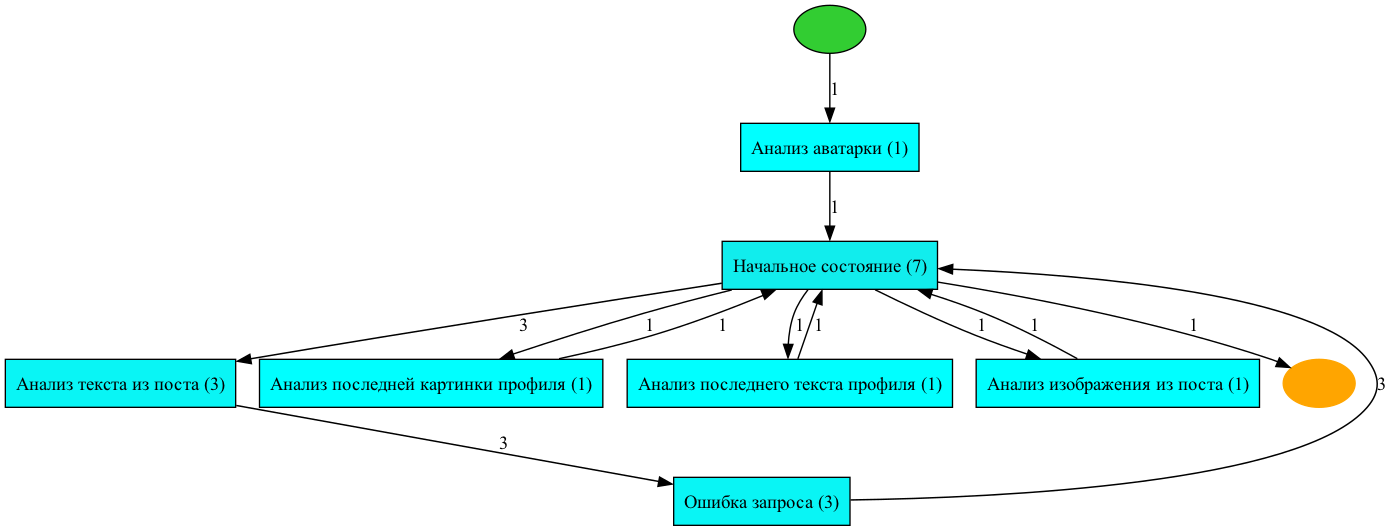

In [17]:
from pm4py.objects.conversion.log import converter as log_conv
logs = log_conv.apply(DF)

from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
heu_net = heuristics_miner.apply_heu(logs)

from pm4py.visualization.heuristics_net import visualizer as hn_vis_factory
gviz = hn_vis_factory.apply(heu_net)
hn_vis_factory.view(gviz)

# Тесты

In [ ]:
import os

import unittest


class BotTest(unittest.TestCase):
    def test_action_type(self):
        event = vk_api.longpoll.Event([0])
        
        event.text="какая-то команда"
        self.assertEqual(define_action(event), -1)
        
        event.text = "анализ аватарки"
        self.assertEqual(define_action(event), -1)

        event.text = "Анализ аватарки"
        self.assertEqual(define_action(event), 0)

    def test_keyword_extraction(self):
        kwe = KeyWordExtractor()
        self.assertEqual(kwe.extract_keywords(""), "")
        self.assertEqual(kwe.extract_keywords("собака"), "собака")

    def test_get_url_user(self):
        person_info = vk.users.get(user_id=428900901, fields='crop_photo')

    def test_get_url_wall(self):
        wall = personal_vk.wall.get(owner_id=428900901)
        url = get_url_wall(wall)

    def test_image_download(self):
        get_np_image_from_url("https://sun75-1.userapi.com/impg/74RStNa9Y7IIM4angyAC83cJynJojwgWjgGC3g/yv0zTOQqrUs.jpg?size=807x605&quality=95&sign=a3eac6a2e4535f3964fb3b16e3986275&c_uniq_tag=vDEgkQJ_VUJuLoJQ2h3u7SI3-vE-_7EEjiVfxPj-Fs0&type=album")

    def test_image_save(self):
        np_image = get_np_image_from_url("https://sun75-1.userapi.com/impg/74RStNa9Y7IIM4angyAC83cJynJojwgWjgGC3g/yv0zTOQqrUs.jpg?size=807x605&quality=95&sign=a3eac6a2e4535f3964fb3b16e3986275&c_uniq_tag=vDEgkQJ_VUJuLoJQ2h3u7SI3-vE-_7EEjiVfxPj-Fs0&type=album")
        save_np_image(np_image, save_path="aboba.jpg")
        assert "aboba.jpg" in os.listdir()
    
    def test_keyboard(self):
        self.assertEqual(type(_get_settings_keyboard()), str)

    def test_initial_bot_state(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        self.assertEqual(len(bot.events), 0)

    def test_analyze_user_avatar(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = 428900901
        event.user_id = 428900901

        self.assertEqual(bot.analyze_user_avatar(event), "ok")

    def test_analyze_user_last_image(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = 428900901
        event.user_id = 428900901

        self.assertEqual(bot.analyze_user_last_image(event), "ok")

    def test_analyze_user_last_text(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = 428900901
        event.user_id = 428900901

        self.assertEqual(bot.analyze_user_last_text(event), "ok")

    def test_analyze_post_image(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = "428900901_61"
        event.user_id = 428900901

        self.assertEqual(bot.analyze_post_image(event), "ok")

    def test_analyze_post_text(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = "428900901_61"
        event.user_id = 428900901

        self.assertEqual(bot.analyze_post_text(event), "error")

    def test_get_id(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = 428900901
        event.user_id = 428900901
        
        bot.vk.messages.send(                
                    user_id=event.user_id,
                    random_id=get_random_id(),
                    message=f"Предоставьте интересующий id",
                    keyboard=_get_settings_keyboard(),
                )
        
    def test_unknown_command(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = 428900901
        event.user_id = 428900901
        
        bot.vk.messages.send(                
                        user_id=event.user_id,
                        random_id=get_random_id(),
                        message=f"unknown command {event.text}",
                        keyboard=_get_settings_keyboard(),
                    )

    def test_unknown_attribute(self):
        bot = Bot(longpoll, vk, personal_vk, detector, keyword_extractor)

        event = vk_api.longpoll.Event([0])
        event.text = 428900901
        event.user_id = 428900901

        bot.vk.messages.send(                
                user_id=event.user_id,
                random_id=get_random_id(),
                message=f"Данного id не существует, или нет нужного атрибута",
                keyboard=_get_settings_keyboard(),
            )              


tester = BotTest()
tester.test_action_type()
tester.test_keyword_extraction()
tester.test_get_url_user()
tester.test_get_url_wall()
tester.test_image_download()
tester.test_image_save()
tester.test_keyboard()
tester.test_initial_bot_state()
tester.test_analyze_user_avatar()
tester.test_analyze_user_last_image()
tester.test_analyze_user_last_text()
tester.test_analyze_post_image()
tester.test_analyze_post_text()
tester.test_get_id()
tester.test_unknown_command()
tester.test_unknown_attribute()

**Вывод**: все работает, как надо, баги не обнаружены
тесты покрывабт базовый функционал общения бота и внутренних функций: модеи детекции и языковой модеи для ключевых слов